In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import sklearn as sk

# GPU Setup

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable first GPU
  tf.config.set_visible_devices(physical_devices[:-1], 'GPU')
  logical_devices = tf.config.list_logical_devices('GPU')
  # Logical device was not created for first GPU
  assert len(logical_devices) == len(physical_devices) - 1
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# Data preprocessing

In [3]:
# Build dataset
# python -m tensorflow_datasets.scripts.download_and_prepare --datasets=mri_dataset --module_import=mri_dataset --manual_dir=../../data/mri_dataset

In [4]:
def preprocess(ds, batch_size, ds_type='train'):
    num_classes = 3

    resize_and_rescale = create_resize_and_rescale_layer()
    data_augmentation = create_augmentation_layer()

    if ds_type == 'test':
        ds = ds.map(lambda ds: (ds['image'], ds['label']))

    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)

    if ds_type == 'train':
        ds = ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
    
    if ds_type == 'train' or ds_type == 'valid': 
        ds = ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
    
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


def create_resize_and_rescale_layer(): 
    resize_and_rescale = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE[0], IMG_SIZE[1], interpolation='bilinear'),
        tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
    ], name='resize_and_rescale')
    return resize_and_rescale


def create_augmentation_layer():
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip(),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ], name='data_augmentation')
    # TODO: sheer
    # TODO: Gaussian Filter
    return data_augmentation


class RandomSheer(tf.keras.layers.Layer):
  def __init__(self, intensity=0.1, **kwargs):
    super().__init__(**kwargs)
    self.intensity = intensity

  def call(self, x):
    return x


class RandomGaussionFilter(tf.keras.layers.Layer):
  def __init__(self, mean=0, std=1.0, **kwargs):
    super().__init__(**kwargs)
    self.mean = mean
    self.std = std

  def call(self, x):
    return x


def create_base_model(img_shape):
    # base_model = tf.keras.applications.MobileNetV2(
    #     input_shape=img_shape,
    #     include_top=False,
    #     weights='imagenet'
    # )
    # base_model = tf.keras.applications.EfficientNetB7(
    #     input_shape=img_shape,
    #     include_top=False,
    #     weights='imagenet',
    # )
    base_model = tf.keras.applications.Xception(
        input_shape=img_shape,
        include_top=False,
        weights='imagenet',
    ) 
    base_model.trainable = False
    return base_model


def create_prediction_layer(num_classes):
    prediction = tf.keras.Sequential([
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax'),
    ], name='prediction')
    return prediction


def create_model(image_shape, num_classes):
    base_model = create_base_model(image_shape)
    prediction_layer = create_prediction_layer(num_classes)

    inputs = tf.keras.Input(shape=image_shape)
    x = base_model(inputs, training=False)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    return model


def create_fine_tune_model(model, fine_tune_at=100):
    model.layers[1].trainable = True
    print("Number of layers in the base model: ", len(model.layers[1].layers))

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in model.layers[1].layers[:fine_tune_at]:
        layer.trainable = False
    return model


def compile_and_fit(model, train_ds, valid_ds, hyperparams, start_epoch=0):
    if start_epoch != 0:
        total_epochs =  hyperparams['initial_epochs'] + hyperparams['fine_tune_epochs']
        lr = hyperparams['learning_rate'] / 10
    else:
        total_epochs =  hyperparams['initial_epochs']
        lr = hyperparams['learning_rate']

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=lr),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=hyperparams['label_smoothing']),
        metrics=['accuracy']
    )
    print(model.summary())
    history = model.fit(
        train_ds,
        epochs=total_epochs,
        initial_epoch=start_epoch,
        validation_data=valid_ds
    )
    return model, history


def plot(acc, val_acc, loss, val_loss, initial_epochs=0):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1.0])
    plt.title('Training and Validation Accuracy')
    if initial_epochs != 0:
        plt.plot([initial_epochs-1,initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    if initial_epochs != 0:
        plt.plot([initial_epochs-1,initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')
    plt.show()


def save_results(save_path, image_ids, predicted_labels):
    results = image_ids.drop('image', axis=1)
    results.columns = ['ID', 'Label']
    results['Label'] = predicted_labels 
    results = results.sort_values('ID').reset_index(drop=True)
    results.to_csv(RESULT_SAVE_PATH, index=False)

In [5]:
import tensorflow_datasets as tfds
from datasets.mri_dataset import MriDataset
from tensorflow.data import Dataset


data_folder = 'data'
dataset = 'mri_dataset'
train_label = 'train_label.csv'
train_folder = 'train'
test_folder = 'test'

RESULT_SAVE_PATH = 'submission.csv'
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
IMG_SIZE = (512, 512)
IMG_SHAPE = IMG_SIZE + (3,)
SEED = 0
AUTOTUNE = tf.data.experimental.AUTOTUNE


num_classes = 3
train_folds = tfds.load(
    name='mri_dataset', 
    split=[f'train[:{k}%]+train[{k+10}%:]' for k in range(0, 100, 20)], # 'train[:90%]' 
    download=False, 
    shuffle_files=False, 
    as_supervised=True
)
valid_folds = tfds.load(
    name='mri_dataset', 
    split=[f'train[{k}%:{k+10}%]' for k in range(0, 100, 20)], # 'train[:-10%]' 
    download=False, 
    shuffle_files=False, 
    as_supervised=True
)
test_ds_raw, test_info_raw = tfds.load(
    name='mri_dataset', 
    split='test', 
    download=False, 
    shuffle_files=False, 
    as_supervised=False, 
    with_info=True
)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_folds = [ preprocess(ds, batch_size=TRAIN_BATCH_SIZE, ds_type='train') for ds in train_folds ]
valid_folds = [ preprocess(ds, batch_size=VALID_BATCH_SIZE, ds_type='valid') for ds in valid_folds ]
test_ds = preprocess(test_ds_raw, batch_size=TEST_BATCH_SIZE, ds_type='test')

In [6]:
train_valid_df = pd.read_csv(os.path.join(data_folder, dataset, train_label))
train_ds = train_folds[0]
valid_ds = valid_folds[0]

print(f'Number of train batches: {train_ds.cardinality()}')
print(f'Number of valid batches: {valid_ds.cardinality()}')
print(f'Number of test batches: {test_ds.cardinality()}')

Number of train batches: 33
Number of valid batches: 4
Number of test batches: 10


In [7]:
# Train Data
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(9):
#     for i in range(9):
#       ax = plt.subplot(3, 3, i + 1)
#       plt.imshow(images[i].numpy().astype("uint8"))
#       plt.title(labels[i].numpy())
#       plt.axis("off")

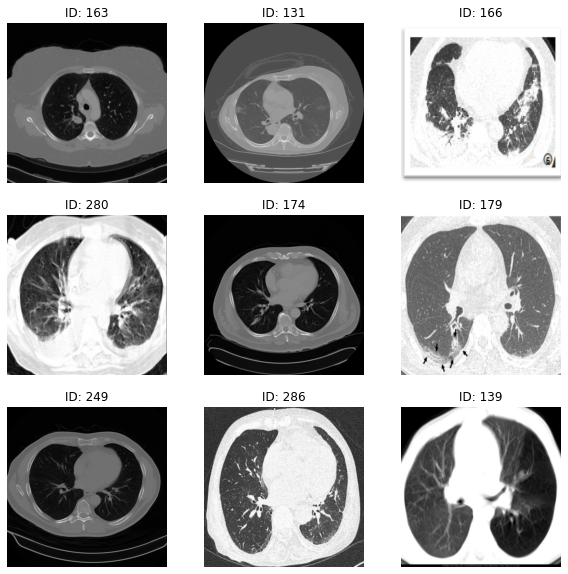

In [8]:
# Test Data
# plt.figure(figsize=(10, 10))
# for i, ds in enumerate(test_ds_raw.take(9)):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(ds['image'].numpy().astype("uint8"))
#     plt.title('ID: {}'.format(ds['id'].numpy()))
#     plt.axis("off")

In [9]:
# data_augmentation = create_augmentation_layer()

# for image, _ in train_ds.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

# Model

# Train and Validate

# -------------------- 1 fold -------------------- #
1 fold pre train:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
prediction (Sequential)      (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
_________________________________________________________________
None
33/33 [==============================] - 9s 275ms/step - loss: 1.0308 - accuracy: 0.4866 - val_loss: 1.0276 - val_accuracy: 0.4138



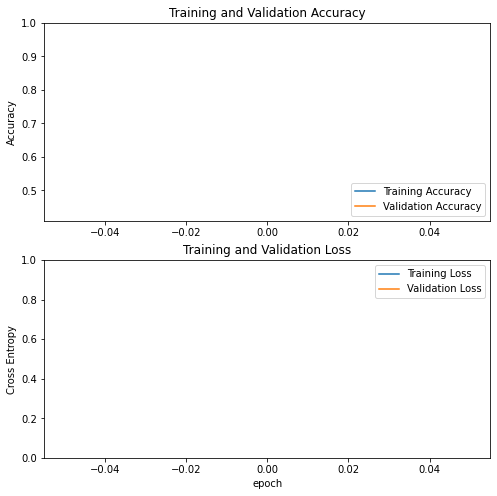


1 fold fine train:
Number of layers in the base model:  132
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
prediction (Sequential)      (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 20,784,587
Non-trainable params: 83,040
_________________________________________________________________
None
33/33 [==============================] - 37s 1s/step - loss: 0.6479 - accuracy: 0.7672 - val_loss: 0.5998 - val_accuracy: 0.7414



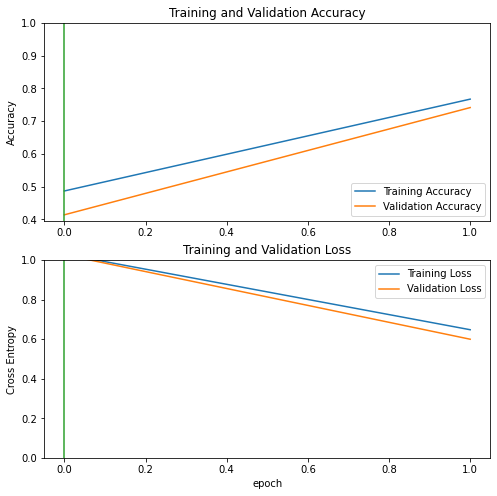


1 fold | Train Accuracy: 0.767175555229187 | Validation Accuracy: 0.7413793206214905 | Train Loss: 0.6478869318962097 | Validation Loss: 0.5998403429985046

# -------------------- 2 fold -------------------- #
2 fold pre train:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
prediction (Sequential)      (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
_________________________________________________________________
None
33/33 [==============================] - 10s 317ms/step - loss: 1.0726 - accuracy: 0.4284 - val_loss: 1.0370 - val_accuracy: 0.4655



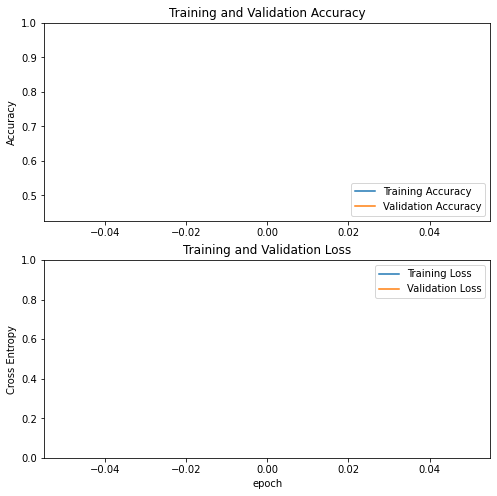


2 fold fine train:
Number of layers in the base model:  132
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
prediction (Sequential)      (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 20,784,587
Non-trainable params: 83,040
_________________________________________________________________
None
33/33 [==============================] - 37s 1s/step - loss: 0.6739 - accuracy: 0.7662 - val_loss: 0.6965 - val_accuracy: 0.7241



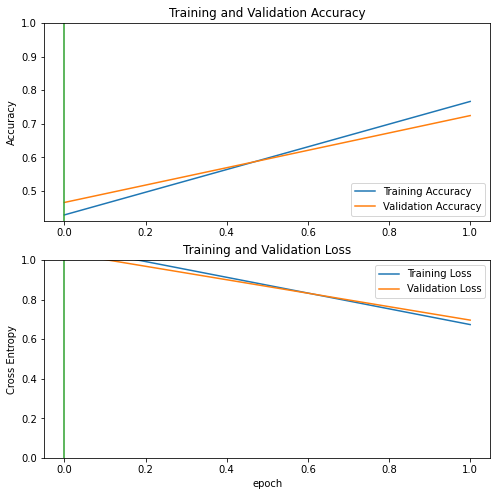


2 fold | Train Accuracy: 0.7662213444709778 | Validation Accuracy: 0.7241379022598267 | Train Loss: 0.6739405393600464 | Validation Loss: 0.6965173482894897

# -------------------- 3 fold -------------------- #
3 fold pre train:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
prediction (Sequential)      (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
_________________________________________________________________
None
33/33 [==============================] - 9s 281ms/step - loss: 1.0686 - accuracy: 0.4151 - val_loss: 1.0122 - val_accuracy: 0.5690



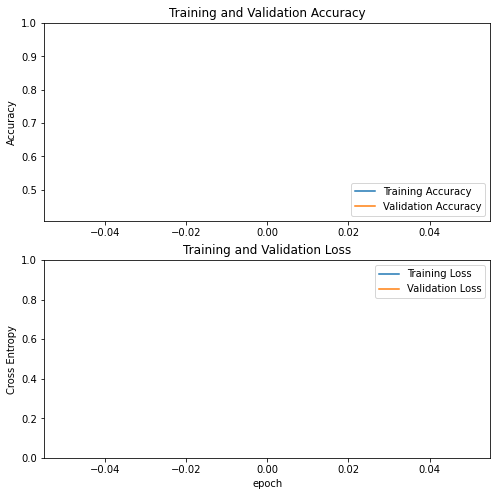


3 fold fine train:
Number of layers in the base model:  132
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
prediction (Sequential)      (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 20,784,587
Non-trainable params: 83,040
_________________________________________________________________
None
33/33 [==============================] - 36s 1s/step - loss: 0.6594 - accuracy: 0.7672 - val_loss: 0.5409 - val_accuracy: 0.8534



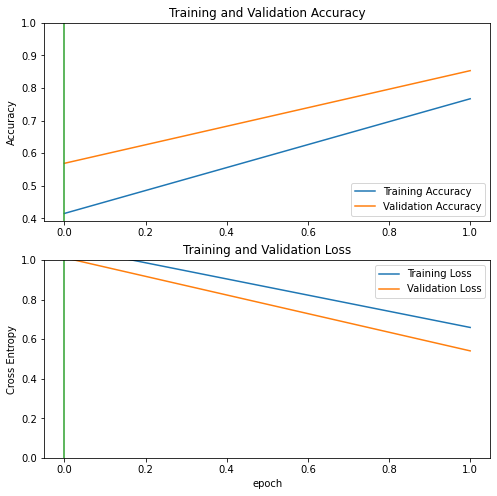


3 fold | Train Accuracy: 0.767175555229187 | Validation Accuracy: 0.8534482717514038 | Train Loss: 0.6594058871269226 | Validation Loss: 0.5409440994262695

# -------------------- 4 fold -------------------- #
4 fold pre train:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
prediction (Sequential)      (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
_________________________________________________________________
None
33/33 [==============================] - 10s 307ms/step - loss: 1.0687 - accuracy: 0.4518 - val_loss: 1.0394 - val_accuracy: 0.4444



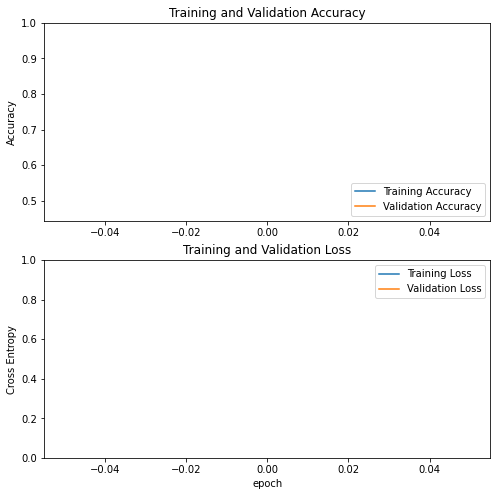


4 fold fine train:
Number of layers in the base model:  132
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
prediction (Sequential)      (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 20,784,587
Non-trainable params: 83,040
_________________________________________________________________
None
33/33 [==============================] - 37s 1s/step - loss: 0.6915 - accuracy: 0.7574 - val_loss: 0.6283 - val_accuracy: 0.7863



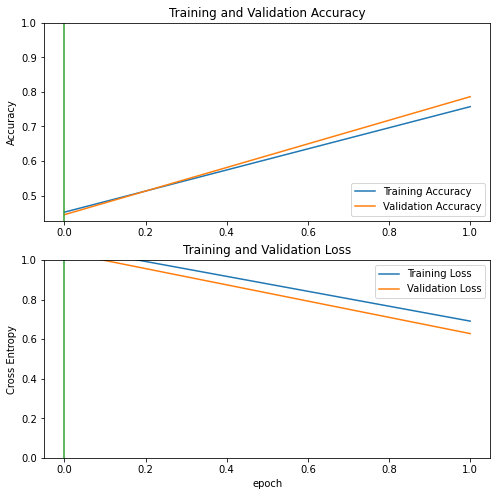


4 fold | Train Accuracy: 0.7574021220207214 | Validation Accuracy: 0.7863247990608215 | Train Loss: 0.6914639472961426 | Validation Loss: 0.628349244594574

# -------------------- 5 fold -------------------- #
5 fold pre train:
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
prediction (Sequential)      (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
_________________________________________________________________
None
33/33 [==============================] - 10s 302ms/step - loss: 1.0707 - accuracy: 0.4174 - val_loss: 1.0501 - val_accuracy: 0.4444



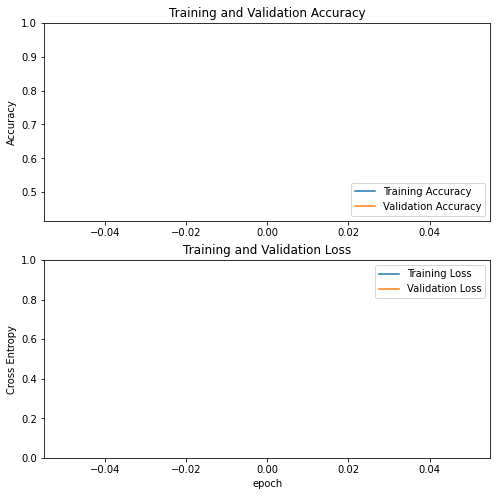


5 fold fine train:
Number of layers in the base model:  132
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 16, 16, 2048)      20861480  
_________________________________________________________________
prediction (Sequential)      (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 20,784,587
Non-trainable params: 83,040
_________________________________________________________________
None
33/33 [==============================] - 36s 1s/step - loss: 0.6437 - accuracy: 0.7603 - val_loss: 0.5533 - val_accuracy: 0.8120



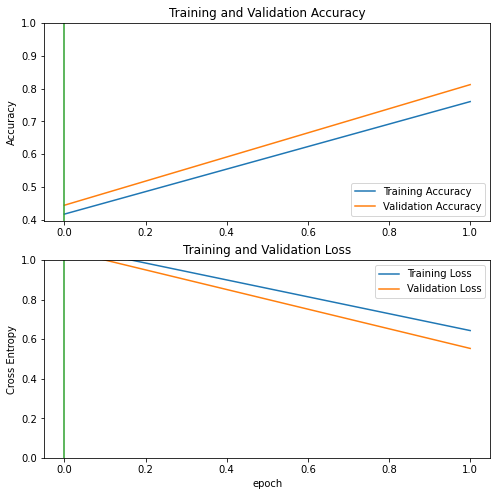


5 fold | Train Accuracy: 0.760267436504364 | Validation Accuracy: 0.811965823173523 | Train Loss: 0.6436863541603088 | Validation Loss: 0.5532963275909424

Avg Train Accuracy: 0.7636484026908874 | Avg Validation Accuracy: 0.7834512233734131 | Avg Train Loss: 0.6436863541603088 | Avg Validation Loss: 0.5532963275909424
CPU times: user 20min 1s, sys: 7min 49s, total: 27min 50s
Wall time: 4min 52s


In [10]:
%%time

tf.random.set_seed(SEED)
hyperparams = {
    'initial_epochs': 1,
    'fine_tune_epochs': 1,
    'learning_rate': 1e-4,
    'label_smoothing': 0.1,
    'fine_tune_at': 10,
}

train_accs, valid_accs, train_losses, valid_losses = [], [], [], []
for i, (train_ds, valid_ds) in enumerate(zip(train_folds, valid_folds)):
    k = i + 1
    print(f'# -------------------- {k} fold -------------------- #')
    tf.keras.backend.clear_session()
    model = create_model(IMG_SHAPE, num_classes)
    
    print(f'{k} fold pre train:') 
    model, history = compile_and_fit(model, train_ds, valid_ds, hyperparams)
    print()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plot(acc, val_acc, loss, val_loss)
    print()

    print(f'{k} fold fine train:')
    model = create_fine_tune_model(model, fine_tune_at=hyperparams['fine_tune_at'])
    model, history_fine = compile_and_fit(model, train_ds, valid_ds, hyperparams, start_epoch=history.epoch[-1]) # TODO: Re-prefetch ds
    print()

    acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']
    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']
    plot(acc, val_acc, loss, val_loss, initial_epochs=hyperparams['initial_epochs'])
    print()

    # record accuracy
    train_acc = history.history['accuracy'][-1]
    valid_acc = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    valid_loss = history.history['val_loss'][-1]

    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'{k} fold | Train Accuracy: {train_acc} | Validation Accuracy: {valid_acc} | Train Loss: {train_loss} | Validation Loss: {valid_loss}\n')

# average accuracy
avg_train_acc = np.mean(train_accs)
avg_valid_acc = np.mean(valid_accs)
avg_train_loss = np.mean(train_loss)
avg_valid_loss = np.mean(valid_loss)

print(f'Avg Train Accuracy: {avg_train_acc} | Avg Validation Accuracy: {avg_valid_acc} | Avg Train Loss: {avg_train_loss} | Avg Validation Loss: {avg_valid_loss}')

# Prediction

In [11]:
tf.random.set_seed(SEED)

# TODO: combine ds and retrain
# combined_ds = train_folds[0].concatenate(valid_folds[0])

In [12]:
# image_batch, label_batch = valid_ds.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch)
# predicted_indices = tf.argmax(predictions, 1)
# predicted_labels = predicted_indices.numpy()


# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(f'pred: {predicted_labels[i]} true: {label_batch[i]}')
#   plt.axis("off")

# Evaluate

In [13]:
predictions = model.predict(test_ds)
predicted_indices = tf.argmax(predictions, 1)
predicted_labels = predicted_indices.numpy()
predicted_labels

array([2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1,
       1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 0, 1, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1,
       1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 0, 2,
       1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 0, 1, 1, 2, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2,
       1, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 0, 1, 1, 0, 1, 2, 1, 1, 1, 2, 0, 1, 0, 2, 2, 1, 1, 1, 0, 2,
       1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 1])

In [14]:
img_ids = tfds.as_dataframe(test_ds_raw, test_info_raw)
save_results(RESULT_SAVE_PATH, img_ids, predicted_labels)

# Main

In [15]:
# Data
# train
    # kfold
    # whole ds
# evaluate